In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle

In [6]:
# 1) internal planning  + explicit search
# 2) external planning - implicit search
# 3) external planning - explciit search

In [7]:
df.loc[20].token_df.shape[0]

NameError: name 'df' is not defined

In [8]:
df["success_rate"]

NameError: name 'df' is not defined

In [9]:
(df.loc[20].token_df["usd_cost"].sum() + 
df.loc[10].token_df["usd_cost"].sum() + 
df.loc[5].token_df["usd_cost"].sum())

NameError: name 'df' is not defined

In [10]:
df.loc[20].time_df

NameError: name 'df' is not defined

In [11]:
df.loc[20].mcts_df.describe()

NameError: name 'df' is not defined

In [12]:
df.loc[20].token_df.describe()

NameError: name 'df' is not defined

In [13]:
df.loc[20].token_df.hist()

NameError: name 'df' is not defined

In [14]:
tag = "d5"

successes = 0
failures = 0
errors = 0

results_dir = "./results"
exp_names = os.listdir(results_dir)
for exp_name in exp_names:
  if tag in exp_name:

    # aggregate stats from status.txt
    with open(os.path.join(results_dir, exp_name, "status.txt")) as f:
      for line in f.readlines():
        if line.startswith("webarena"):
          status = line.strip().split(" ")[1]
          print(status)
          if status == "True":
            successes += 1
          elif status == "False":
            failures += 1
          else:
            errors += 1
        else: # otherwise it's error output or something. can ignore. 
          pass

print(successes, failures, errors)


True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
False
False
True
True
False
False
False
ERROR
False
False
False
False
False
True
True
False
False
False
False
False
False
False
False
False
False
False
False
ERROR
False
False
True
False
False
False
True
False
False
False
False
False
False
False
False
True
True
False
False
False
False
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
15 89 2


In [15]:
tag = "d5"

task_token_stats_rows = []
results_dir = "./results"
exp_names = os.listdir(results_dir)
for exp_name in exp_names:
  if tag in exp_name:

    exp_path = os.path.join(results_dir, exp_name)
    task_names = os.listdir(exp_path)

    for task_name in task_names:
      if "webarena" in task_name:

        calls_made = 0
        prompt_tokens = 0
        cached_prompt_tokens = 0
        completion_tokens = 0

        task_path = os.path.join(results_dir, exp_name, task_name)
        items = os.listdir(task_path)
        pickles = [x for x in items if x.endswith(".pkl")]
        for file in pickles:
          if file != "result.pkl":
            pickle_path = os.path.join(task_path, file)
            response = pickle.load(open(pickle_path, "rb"))
            calls_made += 1
            prompt_tokens += response.usage.prompt_tokens
            cached_prompt_tokens += response.usage.prompt_tokens_details.cached_tokens
            completion_tokens += response.usage.completion_tokens

        task_token_stats_rows.append(
          [task_name, calls_made, prompt_tokens, cached_prompt_tokens, completion_tokens]
        )

In [16]:
task_token_df = pd.DataFrame(task_token_stats_rows,
                             columns=["task_name", "llm_calls_made", "prompt_tokens", "prompt_cached_tokens", "completion_tokens"])
task_token_df["total_tokens"] = task_token_df["prompt_tokens"] + task_token_df["completion_tokens"]
task_token_df["prompt_non_cached_tokens"] = task_token_df["prompt_tokens"] - task_token_df["prompt_cached_tokens"]

gpt_4o_mini_input_ppmt = 0.150
gpt_4o_mini_cachedinput_ppmt = 0.075
gpt_4o_mini_output_ppmt = 0.600

task_token_df["usd_cost"] = (task_token_df["prompt_non_cached_tokens"] * gpt_4o_mini_input_ppmt / 1e6 + 
                             task_token_df["prompt_cached_tokens"] * gpt_4o_mini_cachedinput_ppmt / 1e6 + 
                             task_token_df["completion_tokens"] * gpt_4o_mini_output_ppmt / 1e6)
task_token_df = task_token_df[["task_name", "usd_cost", "prompt_tokens", "prompt_cached_tokens", "prompt_non_cached_tokens", "completion_tokens", "total_tokens"]]
task_token_df.set_index("task_name", inplace=True)

In [17]:
task_token_df

,usd_cost,prompt_tokens,prompt_cached_tokens,prompt_non_cached_tokens,completion_tokens,total_tokens
task_name,,,,,,
webarena.729,0.076765,311490,156288,155202,69605,381095
webarena.728,0.019177,112349,65792,46557,12099,124448
webarena.623,0.016902,61611,19200,42411,15168,76779
webarena.638,0.041498,91548,66816,24732,54628,146176
webarena.714,0.144363,935611,324736,610875,47294,982905
...,...,...,...,...,...,...
webarena.620,0.036802,124030,47488,76542,36266,160296
webarena.69,0.017008,82730,10240,72490,8945,91675
webarena.28,0.048700,193754,157056,36698,52361,246115


In [18]:
task_token_summary_stats = task_token_df.describe()
totals = task_token_df.sum(axis=0)
totals.name = "sum"
task_token_summary_stats = pd.concat([task_token_summary_stats, totals.to_frame().T])
task_token_summary_stats

,usd_cost,prompt_tokens,prompt_cached_tokens,prompt_non_cached_tokens,completion_tokens,total_tokens
count,106.000000,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02,1.060000e+02
mean,0.045866,2.009572e+05,1.068196e+05,9.413754e+04,3.955598e+04,2.405131e+05
std,0.022766,1.549051e+05,1.008179e+05,7.821666e+04,1.845806e+04,1.624249e+05
min,0.002853,8.900000e+03,0.000000e+00,8.645000e+03,1.125000e+03,1.143000e+04
25%,0.031084,9.741900e+04,3.894400e+04,5.236950e+04,2.779625e+04,1.322762e+05
50%,0.043221,1.513930e+05,6.572800e+04,7.301500e+04,4.135600e+04,1.828765e+05
75%,0.059408,2.561140e+05,1.568640e+05,1.126328e+05,5.362600e+04,3.074132e+05
max,0.144363,9.356110e+05,3.857920e+05,6.108750e+05,7.260100e+04,9.829050e+05
sum,4.861763,2.130146e+07,1.132288e+07,9.978579e+06,4.192934e+06,2.549439e+07


In [19]:
tag = "d5"

task_time_stats_rows = []
results_dir = "./results"
exp_names = os.listdir(results_dir)
for exp_name in exp_names:
  if tag in exp_name:

    exp_path = os.path.join(results_dir, exp_name)
    task_names = os.listdir(exp_path)

    for task_name in task_names:
      if "webarena" in task_name:
        
        total_proposal_time = 0
        total_evaluation_time = 0
        total_envstep_time = 0
        total_time_taken = 0

        task_path = os.path.join(results_dir, exp_name, task_name)
        with open(os.path.join(task_path, "time.txt")) as f:
          for line in f.readlines():

            if line.startswith("action proposal time"):
              total_proposal_time += float(line.strip().split(": ")[1])
            elif line.startswith("total action evaluation time"):
              total_evaluation_time += float(line.strip().split(": ")[1])
            elif line.startswith("env step time"):
              total_envstep_time += float(line.strip().split(": ")[1])
            elif line.startswith("total time taken"):
              total_time_taken = float(line.strip().split(": ")[1])
        
        task_time_stats_rows.append([task_name, total_time_taken, total_proposal_time, total_evaluation_time, total_envstep_time])

In [20]:
task_time_df = pd.DataFrame(task_time_stats_rows,
                             columns=["task_name", "total_time_taken", "total_proposal_time", "total_evaluation_time", "total_envstep_time"])
task_time_df

,task_name,total_time_taken,total_proposal_time,total_evaluation_time,total_envstep_time
0,webarena.729,589.659158,140.036633,198.752823,129.651548
1,webarena.728,110.914623,36.157659,36.614235,22.630563
2,webarena.623,135.333764,51.458425,40.755002,28.413533
3,webarena.638,439.820382,107.090739,114.587885,100.890331
4,webarena.714,465.466817,129.833860,122.362351,112.162746
...,...,...,...,...,...
101,webarena.620,400.291809,76.957690,121.038710,74.885211
102,webarena.69,65.512595,23.970613,24.328228,6.149816
103,webarena.28,348.646215,98.353005,145.603380,28.817309
104,webarena.602,323.516307,78.560777,101.577165,79.128021


In [21]:
from analysis import get_success_stats, get_token_stats, get_time_stats, get_mcts_stats

In [22]:
from itertools import chain

success_stats = get_success_stats("d5")
token_stats = get_token_stats("d5")
time_stats = get_time_stats("d5")
stats = list(chain(success_stats, token_stats, time_stats))
stats

[5,
 15,
 89,
 2,
 np.float64(4.861763250000001),
 np.float64(0.045865691037735856),
         task_name  usd_cost  prompt_tokens  prompt_cached_tokens  \
 0    webarena.729  0.076765         311490                156288   
 1    webarena.728  0.019177         112349                 65792   
 2    webarena.623  0.016902          61611                 19200   
 3    webarena.638  0.041498          91548                 66816   
 4    webarena.714  0.144363         935611                324736   
 ..            ...       ...            ...                   ...   
 101  webarena.620  0.036802         124030                 47488   
 102   webarena.69  0.017008          82730                 10240   
 103   webarena.28  0.048700         193754                157056   
 104  webarena.602  0.040251         130235                 67200   
 105  webarena.615  0.069365         218248                 88832   
 
      prompt_non_cached_tokens  completion_tokens  total_tokens  
 0                 

In [23]:
# finding out the mcts iterations needed for a task

mcts_result = pickle.load(open("./results/d20-1/webarena.727/result.pkl", "rb"))

/home/samuel/miniconda3/envs/py3117/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/samuel/miniconda3/envs/py3117/lib/python3.11/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [24]:
for trace in mcts_result.trace_in_each_iter:
  print(len(trace))

5
5
7
7
7
7
7
7
7
7


In [25]:
for trace in mcts_result.trace_in_each_iter:
  print(len(trace))

5
5
7
7
7
7
7
7
7
7


In [26]:
len(mcts_result.trace_in_each_iter[-1])

7

In [27]:
len(max(mcts_result.trace_in_each_iter, key=lambda x: len(x)))

7

In [28]:
last_trace = mcts_result.trace_in_each_iter[-1]

same_info = []
for idx, trace in enumerate(mcts_result.trace_in_each_iter):
  same_trace = True
  for n1, n2 in zip(trace, last_trace):
    if n1.id != n2.id:
      same_trace = False
      break
  same_info.append(same_trace)
  print(f"trace {idx} - {same_trace}")
    
for idx, si in enumerate(same_info):
  if si:
    print(f"task completed at iteration {idx}")
    break
# second_last_trace = mcts_result.trace_in_each_iter[-2]
# last_trace[0].id, second_last_trace[0].id

trace 0 - False
trace 1 - False
trace 2 - True
trace 3 - True
trace 4 - True
trace 5 - True
trace 6 - True
trace 7 - True
trace 8 - True
trace 9 - True
task completed at iteration 2


In [29]:
from analysis import find_completion_iteration

In [30]:
import numpy as np

tag = "d5"

task_iteration_stats_rows = []
results_dir = "./results"
exp_names = os.listdir(results_dir)
for exp_name in exp_names:
  if tag in exp_name:

    exp_path = os.path.join(results_dir, exp_name)
    task_names = os.listdir(exp_path)

    for task_name in task_names:
      if "webarena" in task_name:
        task_path = os.path.join(results_dir, exp_name, task_name)
        if os.path.exists(os.path.join(task_path, "result.pkl")):
          mcts_result = pickle.load(open(os.path.join(task_path, "result.pkl"), "rb"))
          if mcts_result.cum_reward >= 100: # task successfully completed
            completion_iteration = find_completion_iteration(mcts_result)
            task_iteration_stats_rows.append([task_name, completion_iteration])
          else:
            task_iteration_stats_rows.append([task_name, np.nan])
        else:
          task_iteration_stats_rows.append([task_name, np.nan])

array([[<Axes: title={'center': 'completion_iteration'}>]], dtype=object)

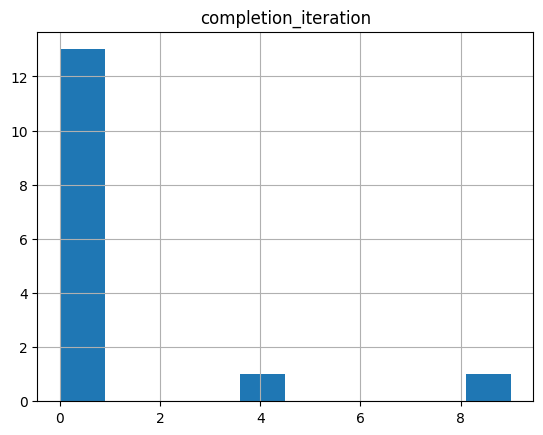

In [31]:
task_iteration_df = pd.DataFrame(task_iteration_stats_rows,
                             columns=["task_name", "completion_iteration"])
task_iteration_df.set_index("task_name", inplace=True)
task_iteration_df.hist()

In [32]:
from analysis import get_stats

In [33]:
d5_stats = get_stats("d5")
d10_stats = get_stats("d10")
d20_stats = get_stats("d20")

df = pd.DataFrame([d5_stats, d10_stats, d20_stats], 
                  columns=["mcts_depth", "successes", "failures", "errors", "total_usd", "avg_usd", "token_df", "total_time", "avg_time", "time_df", "avg_completion_iteration", "avg_completion_depth", "mcts_df"])
df.set_index("mcts_depth", inplace=True)
df["success_rate"] = df["successes"] / (df[["successes", "failures", "errors"]].sum(axis=1))
df = df[["success_rate", "total_usd", "avg_usd", "total_time", "avg_time", "avg_completion_iteration", "avg_completion_depth", "successes", "failures", "errors", "token_df", "time_df", "mcts_df"]]
df

,success_rate,total_usd,avg_usd,total_time,avg_time,avg_completion_iteration,avg_completion_depth,successes,failures,errors,token_df,time_df,mcts_df
mcts_depth,,,,,,,,,,,,,
5,0.141509,4.861763,0.045866,40834.997811,385.235828,0.866667,4.266667,15,89,2,task_name usd_cost prompt_tokens pr...,task_name total_time_taken total_pro...,completion_iteration completion...
10,0.198113,6.413142,0.060501,57128.987742,538.952715,0.857143,5.238095,21,82,3,task_name usd_cost prompt_tokens pr...,task_name total_time_taken total_pro...,completion_iteration completion...
20,0.330189,9.009063,0.084991,91408.657527,862.345826,0.600000,7.314286,35,67,4,task_name usd_cost prompt_tokens pr...,task_name total_time_taken total_pro...,completion_iteration completion...


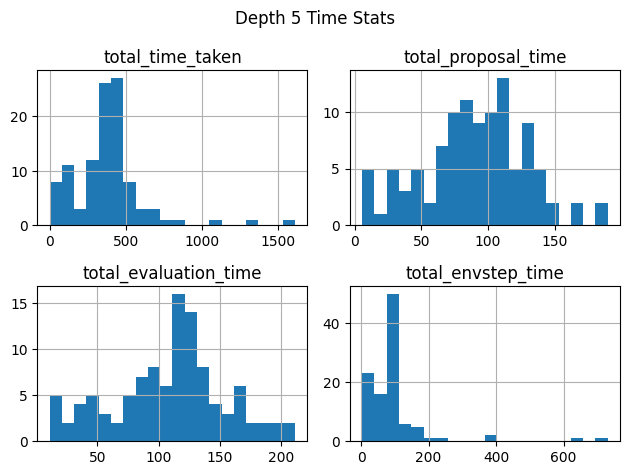

In [34]:
df.loc[5].time_df.hist(bins=20)
plt.suptitle("Depth 5 Time Stats")
plt.tight_layout()
plt.show()

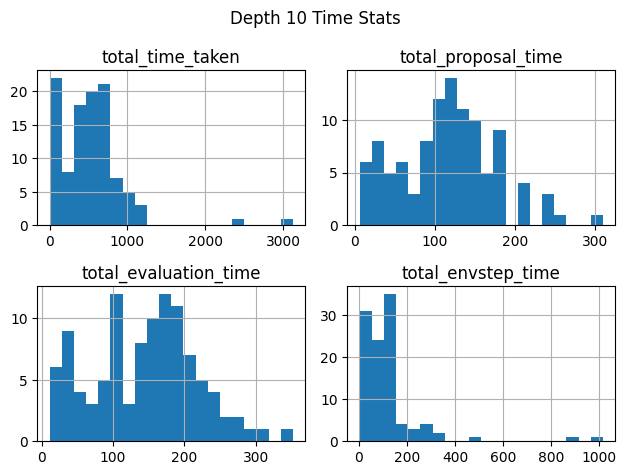

In [35]:
df.loc[10].time_df.hist(bins=20)
plt.suptitle("Depth 10 Time Stats")
plt.tight_layout()
plt.show()

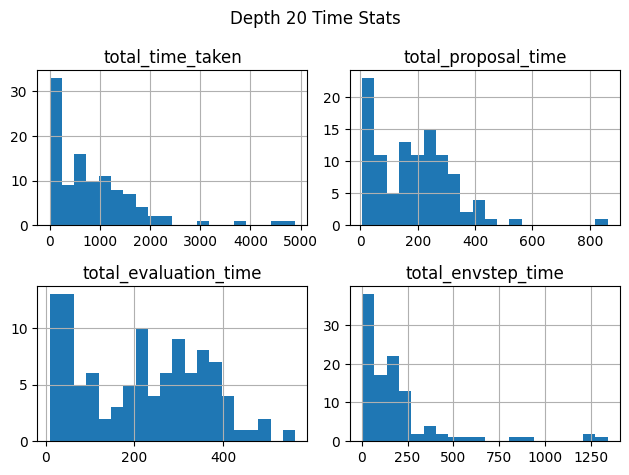

In [36]:
df.loc[20].time_df.hist(bins=20)
plt.suptitle("Depth 20 Time Stats")
plt.tight_layout()
plt.show()

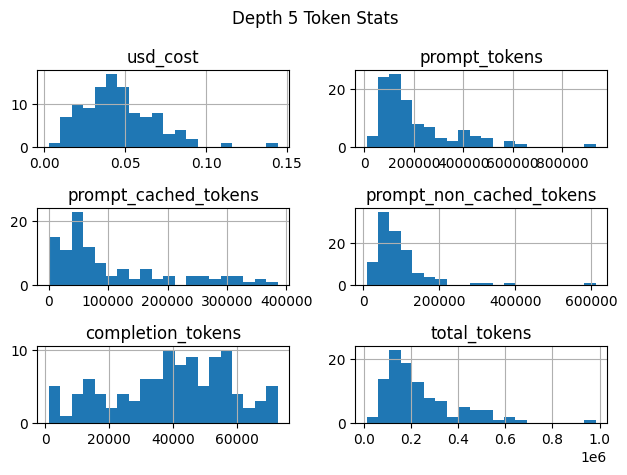

In [37]:
df.loc[5].token_df.hist(bins=20)
plt.suptitle("Depth 5 Token Stats")
plt.tight_layout()
plt.show()

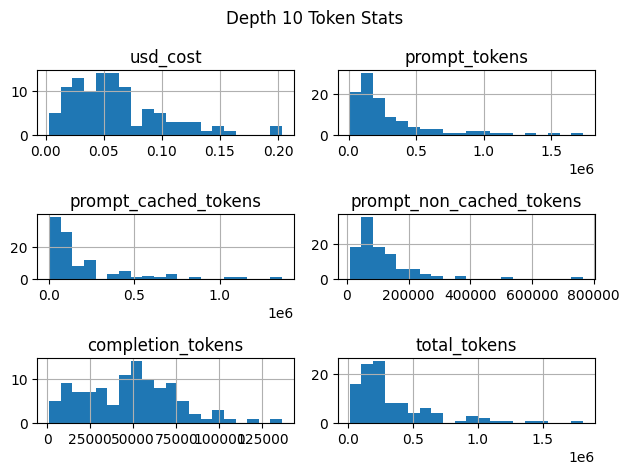

In [38]:
df.loc[10].token_df.hist(bins=20)
plt.suptitle("Depth 10 Token Stats")
plt.tight_layout()
plt.show()

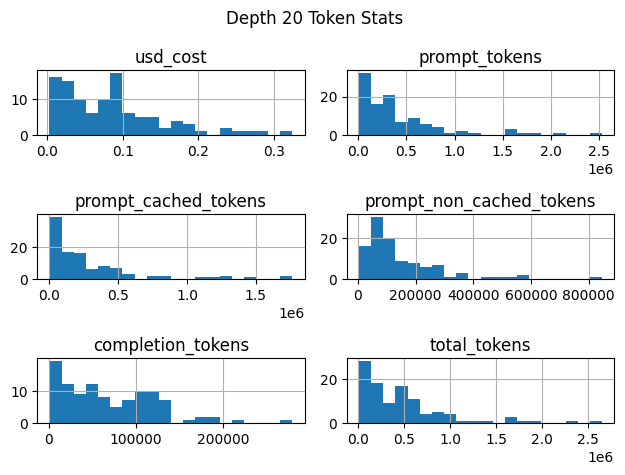

In [39]:
df.loc[20].token_df.hist(bins=20)
plt.suptitle("Depth 20 Token Stats")
plt.tight_layout()
plt.show()

In [40]:
df.loc[5].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0    2
3.0    1
4.0    7
5.0    1
6.0    4
Name: count, dtype: int64

In [41]:
df.loc[10].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0     2
3.0     2
4.0     2
5.0     7
6.0     5
8.0     1
9.0     1
10.0    1
Name: count, dtype: int64

In [42]:
df["successes"]

mcts_depth
5     15
10    21
20    35
Name: successes, dtype: int64

In [43]:
df.loc[10].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0     2
3.0     2
4.0     2
5.0     7
6.0     5
8.0     1
9.0     1
10.0    1
Name: count, dtype: int64

In [44]:
df.loc[20].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0     3
3.0     4
4.0     4
5.0     3
6.0     2
7.0     7
8.0     5
9.0     1
10.0    1
12.0    1
16.0    1
19.0    2
21.0    1
Name: count, dtype: int64

In [45]:
(df.loc[10].mcts_df["completion_iteration"] > -1) 

task_name
webarena.729    False
webarena.728     True
webarena.623     True
webarena.638    False
webarena.714    False
                ...  
webarena.620    False
webarena.69     False
webarena.28     False
webarena.602    False
webarena.615    False
Name: completion_iteration, Length: 106, dtype: bool

In [46]:
df.loc[20].mcts_df[(df.loc[20].mcts_df["completion_iteration"] > -1) & ((df.loc[10].mcts_df["completion_iteration"] > -1) )].shape[0]

/tmp/ipykernel_2634411/3651096995.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.loc[20].mcts_df[(df.loc[20].mcts_df["completion_iteration"] > -1) & ((df.loc[10].mcts_df["completion_iteration"] > -1) )].shape[0]


16

In [47]:
df.loc[10].mcts_df[(df.loc[10].mcts_df["completion_iteration"] > 0) & (df.loc[10].mcts_df["completion_depth"] <= 6)]

,completion_iteration,completion_depth,max_depth,env_steps_taken
task_name,,,,
webarena.67,2.0,6.0,6.0,14.0
webarena.30,2.0,4.0,4.0,10.0
webarena.400,6.0,5.0,5.0,23.0


In [48]:
df.loc[20].mcts_df[(df.loc[20].mcts_df["completion_iteration"] > 0) & (df.loc[20].mcts_df["completion_depth"] <= 11)]

,completion_iteration,completion_depth,max_depth,env_steps_taken
task_name,,,,
webarena.408,8.0,4.0,4.0,22.0
webarena.598,2.0,8.0,8.0,20.0
webarena.401,2.0,7.0,7.0,11.0
webarena.727,2.0,7.0,7.0,17.0


In [49]:
df["successes"]

mcts_depth
5     15
10    21
20    35
Name: successes, dtype: int64

In [50]:
df.loc[10].mcts_df.value_counts()

completion_iteration  completion_depth  max_depth  env_steps_taken
0.0                   5.0               5.0        5.0                6
                      6.0               6.0        6.0                4
                      2.0               2.0        2.0                2
                      3.0               3.0        3.0                2
                      4.0               4.0        4.0                1
                      8.0               8.0        8.0                1
                      9.0               9.0        9.0                1
2.0                   4.0               4.0        10.0               1
                      6.0               6.0        14.0               1
6.0                   5.0               5.0        23.0               1
8.0                   10.0              11.0       80.0               1
Name: count, dtype: int64

In [51]:
df.loc[20].mcts_df.value_counts()

completion_iteration  completion_depth  max_depth  env_steps_taken
0.0                   7.0               7.0        7.0                5
                      3.0               3.0        3.0                4
                      8.0               8.0        8.0                4
                      2.0               2.0        2.0                3
                      5.0               5.0        5.0                3
                      4.0               4.0        4.0                3
                      6.0               6.0        6.0                2
                      9.0               9.0        9.0                1
                      10.0              10.0       10.0               1
                      12.0              12.0       12.0               1
                      16.0              16.0       16.0               1
                      21.0              21.0       21.0               1
2.0                   7.0               7.0        11.0              

In [52]:
df[["success_rate", "successes", "failures", "errors"]]

,success_rate,successes,failures,errors
mcts_depth,,,,
5,0.141509,15,89,2
10,0.198113,21,82,3
20,0.330189,35,67,4


In [53]:
df[["total_usd", "avg_usd"]]

,total_usd,avg_usd
mcts_depth,,
5,4.861763,0.045866
10,6.413142,0.060501
20,9.009063,0.084991


In [54]:
df[["total_time", "avg_time"]]

,total_time,avg_time
mcts_depth,,
5,40834.997811,385.235828
10,57128.987742,538.952715
20,91408.657527,862.345826


In [55]:
with open(f"depth_experiment_df.pkl", "wb") as f:
  pickle.dump(df, f)

In [56]:
df.loc[5].token_df.sum()["prompt_cached_tokens"] / df.loc[20].token_df.sum()["total_tokens"]

np.float64(0.21518763808320687)

In [57]:
df.loc[10].token_df.sum()["prompt_cached_tokens"] / df.loc[20].token_df.sum()["total_tokens"]

np.float64(0.3818400765842733)

In [58]:
df.loc[20].token_df.sum()["prompt_cached_tokens"] / df.loc[20].token_df.sum()["total_tokens"]

np.float64(0.5618936986507974)

In [59]:
df.loc[5].token_df

,task_name,usd_cost,prompt_tokens,prompt_cached_tokens,prompt_non_cached_tokens,completion_tokens,total_tokens
0,webarena.729,0.076765,311490,156288,155202,69605,381095
1,webarena.728,0.019177,112349,65792,46557,12099,124448
2,webarena.623,0.016902,61611,19200,42411,15168,76779
3,webarena.638,0.041498,91548,66816,24732,54628,146176
4,webarena.714,0.144363,935611,324736,610875,47294,982905
...,...,...,...,...,...,...,...
101,webarena.620,0.036802,124030,47488,76542,36266,160296
102,webarena.69,0.017008,82730,10240,72490,8945,91675
103,webarena.28,0.048700,193754,157056,36698,52361,246115
104,webarena.602,0.040251,130235,67200,63035,42927,173162


In [60]:
df.loc[5].mcts_df.describe()

,completion_iteration,completion_depth,max_depth,env_steps_taken
count,15.000000,15.000000,15.000000,15.000000
mean,0.866667,4.266667,4.400000,9.466667
std,2.474633,1.334523,1.404076,15.037414
min,0.000000,2.000000,2.000000,2.000000
25%,0.000000,4.000000,4.000000,4.000000
50%,0.000000,4.000000,4.000000,4.000000
75%,0.000000,5.500000,6.000000,6.000000
max,9.000000,6.000000,6.000000,58.000000


In [61]:
df.loc[10].mcts_df.describe()

,completion_iteration,completion_depth,max_depth,env_steps_taken
count,21.000000,21.000000,21.000000,21.000000
mean,0.857143,5.238095,5.285714,10.095238
std,2.151411,2.022493,2.148089,16.682041
min,0.000000,2.000000,2.000000,2.000000
25%,0.000000,4.000000,4.000000,5.000000
50%,0.000000,5.000000,5.000000,5.000000
75%,0.000000,6.000000,6.000000,8.000000
max,8.000000,10.000000,11.000000,80.000000


In [62]:
df.loc[10].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0     2
3.0     2
4.0     2
5.0     7
6.0     5
8.0     1
9.0     1
10.0    1
Name: count, dtype: int64

In [63]:
df.loc[20].mcts_df["completion_depth"].value_counts().sort_index()

completion_depth
2.0     3
3.0     4
4.0     4
5.0     3
6.0     2
7.0     7
8.0     5
9.0     1
10.0    1
12.0    1
16.0    1
19.0    2
21.0    1
Name: count, dtype: int64

In [74]:
df.loc[20].mcts_df.env_steps_taken.notna().sum()

np.int64(35)

<Axes: xlabel='completion_depth'>

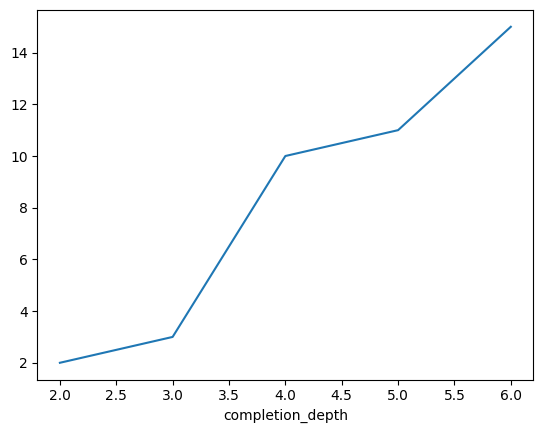

In [64]:
df.loc[5].mcts_df.completion_depth.value_counts().sort_index().cumsum().plot()

<Axes: xlabel='completion_depth'>

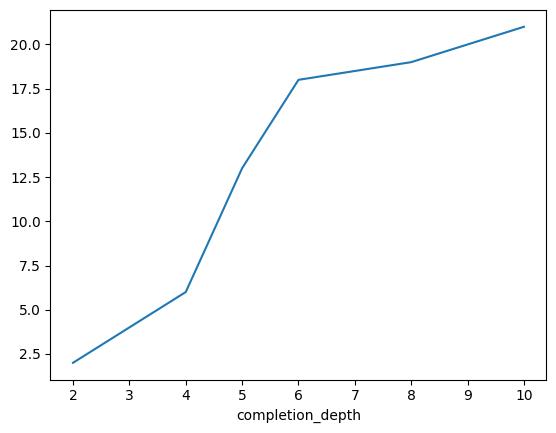

In [82]:
df.loc[10].mcts_df.completion_depth.value_counts().sort_index().cumsum().plot()

In [91]:
df.loc[20].token_df.sort_values("usd_cost", ascending=False)

,task_name,usd_cost,prompt_tokens,prompt_cached_tokens,prompt_non_cached_tokens,completion_tokens,total_tokens
56,webarena.714,0.324518,2531530,1685888,845642,118716,2650246
22,webarena.619,0.288282,1030367,456832,573535,279983,1310350
49,webarena.28,0.272297,2146318,1767168,379150,138145,2284463
36,webarena.31,0.258785,1617441,1063168,554273,159844,1777285
71,webarena.722,0.242422,1235592,714752,520840,184483,1420075
...,...,...,...,...,...,...,...
17,webarena.30,0.011015,43091,17152,25939,9730,52821
12,webarena.582,0.009629,21973,3968,18005,11051,33024
31,webarena.400,0.009412,21273,5504,15769,11056,32329
6,webarena.404,0.005121,8705,4608,4097,6934,15639


In [89]:
df.loc[20].mcts_df.sort_values("completion_depth", ascending=False)

,completion_iteration,completion_depth,max_depth
task_name,,,
webarena.716,0.0,21.0,21.0
webarena.600,4.0,19.0,21.0
webarena.647,3.0,19.0,21.0
webarena.609,0.0,16.0,16.0
webarena.613,0.0,12.0,12.0
...,...,...,...
webarena.733,NaN,NaN,NaN
webarena.646,NaN,NaN,NaN
webarena.648,NaN,NaN,NaN


In [ ]:
df.loc

In [116]:
# 
df.loc[20].mcts_df

,completion_iteration,completion_depth,max_depth
task_name,,,
webarena.581,0.0,8.0,8.0
webarena.29,NaN,NaN,NaN
webarena.409,NaN,NaN,NaN
webarena.403,0.0,8.0,8.0
webarena.584,NaN,NaN,NaN
...,...,...,...
webarena.646,NaN,NaN,NaN
webarena.648,NaN,NaN,NaN
webarena.621,0.0,7.0,7.0


In [118]:
df.loc[20].mcts_df["completion_iteration"].value_counts().sort_values()

completion_iteration
4.0     1
8.0     1
3.0     1
2.0     3
0.0    29
Name: count, dtype: int64

In [119]:
df.loc[20].mcts_df["completion_iteration"] == 0

task_name
webarena.581     True
webarena.29     False
webarena.409    False
webarena.403     True
webarena.584    False
                ...  
webarena.646    False
webarena.648    False
webarena.621     True
webarena.624    False
webarena.725    False
Name: completion_iteration, Length: 106, dtype: bool

Text(0.5, 1.0, 'Tasks Completed V.S. Env Steps Taken')

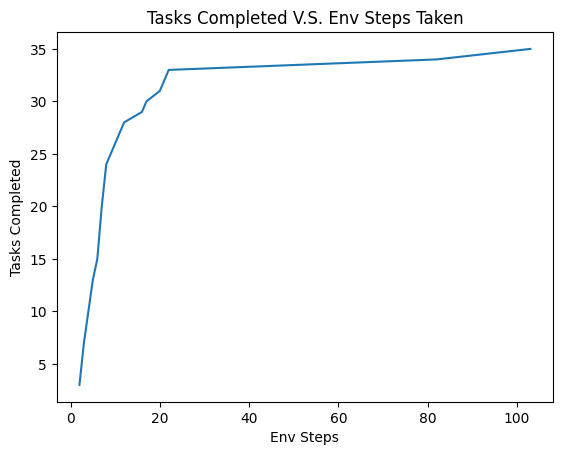

In [81]:
df.loc[20].mcts_df[
(df.loc[20].mcts_df["completion_iteration"] >= 0)
].env_steps_taken.value_counts().sort_index().cumsum().plot()
plt.xlabel("Env Steps")
plt.ylabel("Tasks Completed")
# plt.ylim(0, 1)
plt.title("Tasks Completed V.S. Env Steps Taken")

In [ ]:
df.loc[20].mcts_df[
(df.loc[20].mcts_df["completion_iteration"] == 0)
].env_steps_taken.value_counts().sort_index().cumsum().plot()

<Axes: xlabel='env_steps_taken'>

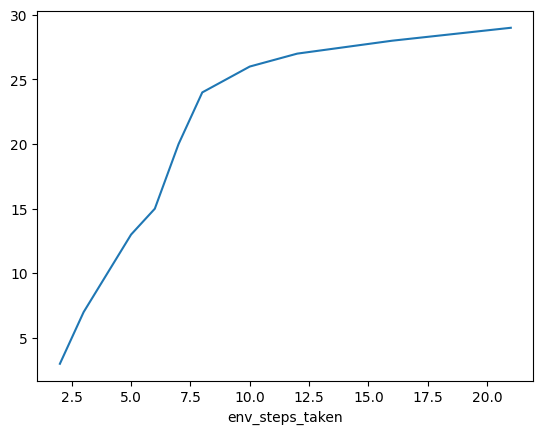

In [75]:
df.loc[20].mcts_df[
(df.loc[20].mcts_df["completion_iteration"] == 0)
].env_steps_taken.value_counts().sort_index().cumsum().plot()

<Axes: xlabel='completion_depth'>

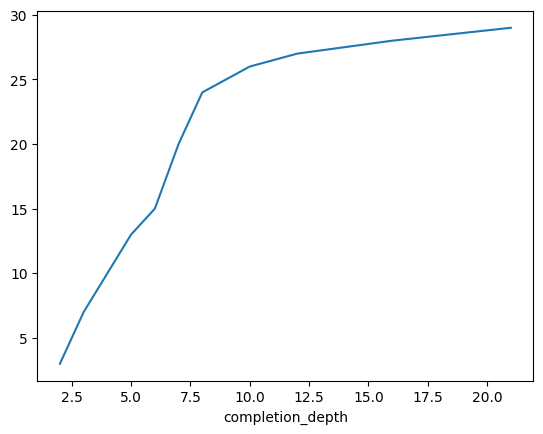

In [122]:
df.loc[20].mcts_df[
(df.loc[20].mcts_df["completion_iteration"] == 0)
].completion_depth.value_counts().sort_index().cumsum().plot()

In [120]:
df.loc[20].mcts_df[
(df.loc[20].mcts_df["completion_iteration"] == 0)
]

,completion_iteration,completion_depth,max_depth
task_name,,,
webarena.581,0.0,8.0,8.0
webarena.403,0.0,8.0,8.0
webarena.605,0.0,2.0,2.0
webarena.582,0.0,4.0,4.0
webarena.596,0.0,4.0,4.0
webarena.609,0.0,16.0,16.0
webarena.399,0.0,6.0,6.0
webarena.607,0.0,3.0,3.0
webarena.610,0.0,9.0,9.0


<Axes: xlabel='completion_depth'>

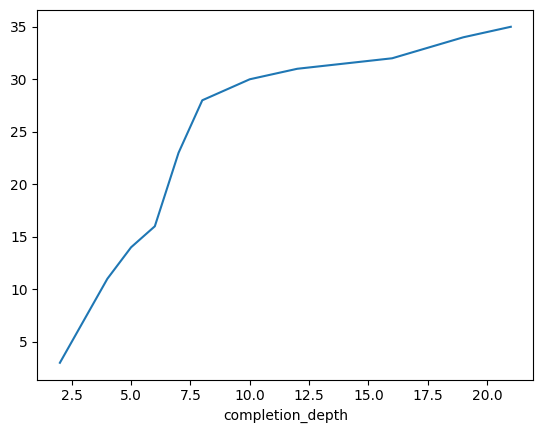

In [83]:
df.loc[20].mcts_df.completion_depth.value_counts().sort_index().cumsum().plot()
plt.xlabel("Depth")
plt.ylabel("Tasks Completed")
# plt.ylim(0, 1)
plt.title("Tasks Completed V.S. Depth")

In [ ]:
import numpy as np

tag = "d5"

task_iteration_stats_rows = []
results_dir = "./results"
exp_names = os.listdir(results_dir)
for exp_name in exp_names:
  if tag in exp_name:

    exp_path = os.path.join(results_dir, exp_name)
    task_names = os.listdir(exp_path)

    for task_name in task_names:
      if "webarena" in task_name:
        task_path = os.path.join(results_dir, exp_name, task_name)
        if os.path.exists(os.path.join(task_path, "result.pkl")):
          mcts_result = pickle.load(open(os.path.join(task_path, "result.pkl"), "rb"))
          if mcts_result.cum_reward >= 100: # task successfully completed
            completion_iteration = find_completion_iteration(mcts_result)
            task_iteration_stats_rows.append([task_name, completion_iteration])
          else:
            task_iteration_stats_rows.append([task_name, np.nan])
        else:
          task_iteration_stats_rows.append([task_name, np.nan])

/tmp/ipykernel_2704942/507405824.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


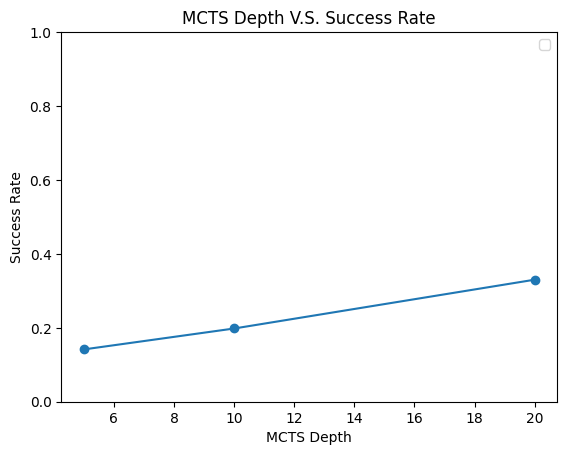

In [13]:
plt.plot(df.index, df["success_rate"], marker="o")
plt.xlabel("MCTS Depth")
plt.ylabel("Success Rate")
plt.ylim(0, 1)
plt.title("MCTS Depth V.S. Success Rate")
plt.legend()
plt.show()